# Implementing McLennan-Tourky in Python

**Daisuke Oyama**  
*Faculty of Economics, University of Tokyo*

In [1]:
%matplotlib inline

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from quantecon.compute_fp import _print_after_skip
from quantecon.game_theory import Player, NormalFormGame, lemke_howson

In [3]:
def compute_fixed_point_ig(f, x_init, error_tol=1e-3, max_iter=50, verbose=1,
                           *args, **kwargs):
    _skip = 1
    if verbose:
        start_time = time.time()
        _print_after_skip(_skip, it=None)
        
    x_new = x_init
    iterate = 0
    y_new = f(x_new, *args, **kwargs)
    error = np.max(np.abs(y_new - x_new))
    
    if error <= error_tol or iterate >= max_iter:
        if verbose:
            etime = time.time() - start_time
            _print_after_skip(_skip, iterate, error, etime)
        return x_new
    
    X = np.array([x_new])
    Y = np.array([y_new])
    x_new = Y[0]
    iterate += 1
    
    while True:
        y_new = f(x_new, *args, **kwargs)
        error = np.max(np.abs(y_new - x_new))
        if error <= error_tol or iterate >= max_iter:
            break
            
        X = np.append(X, np.expand_dims(x_new, axis=0), axis=0)
        Y = np.append(Y, np.expand_dims(y_new, axis=0), axis=0)
        
        m = len(X)
        D = np.expand_dims(X, axis=1) - Y
        D *= D
        A = np.add.reduce(np.atleast_3d(D), axis=-1) * (-1)
        B = np.identity(m)
        g = NormalFormGame((Player(A), Player(B)))
        _, rho = lemke_howson(g, init_pivot=m-1)
        
        x_new = rho.dot(Y)
        iterate += 1
    
    if verbose:
        etime = time.time() - start_time
        _print_after_skip(_skip, iterate, error, etime)
        
    return x_new

## Univariate example

In [4]:
# Just a warmup
compute_fixed_point_ig(lambda x: 0.5*x, 1)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
9            9.766e-04      1.243e+00         


0.001953125

Let us try the logistic function which is well known to generate chaotic behavior.

In [5]:
def logistic(x, r):
    return r * x * (1 - x)

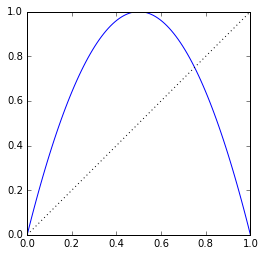

In [6]:
x = np.linspace(0, 1, 100)
y = logistic(x, r=4)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot([0, 1], [0, 1], ':', color='k')
ax.set_aspect(1)
plt.show()

In [7]:
tol = 1e-5
x_init = 0.99
compute_fixed_point_ig(logistic, x_init, error_tol=tol, r=4)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
13           3.322e-07      2.518e-03         


0.74999988927957317

Comare `compute_fixed_point` from `quantecon`:

In [8]:
qe.compute_fixed_point(logistic, x_init, error_tol=tol, r=4)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            9.949e-01      1.080e-04         
10           6.885e-02      1.829e-04         
15           4.956e-01      2.508e-04         
20           8.997e-01      3.190e-04         
25           9.216e-01      3.848e-04         
30           3.289e-01      4.518e-04         
35           5.585e-01      5.169e-04         
40           3.872e-01      5.848e-04         
45           3.619e-01      6.518e-04         
50           1.202e-01      7.188e-04         


0.16269652754236544

## Example 4.6: 500-variable example

In [9]:
def f(x, M, c):
    return -np.arctan(np.dot(M, (x - c)**3)) + c

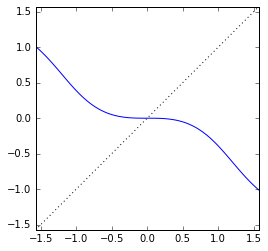

In [10]:
x_min, x_max = -np.pi/2, np.pi/2
x = np.linspace(x_min, x_max, 100)
M = np.abs(np.random.randn())
c = 0
y = f(x, M, c)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim(x_min, x_max)
ax.set_ylim(x_min, x_max)
ax.plot([x_min, x_max], [x_min, x_max], ':', color='k')
ax.set_aspect(1)
plt.show()

In [11]:
n = 500
tol = 1e-5
max_iter = 200

In [12]:
num_trials = 3

for i in range(num_trials):
    print("===== Experiment {} =====\n".format(i))
    c = np.random.standard_normal(n)
    M = np.abs(np.random.standard_normal(size=(n, n)))
    x_init = (np.random.rand(n)-1/2)*np.pi + c
    
    print("***Imitation game***")
    x0 = compute_fixed_point_ig(f, x_init, tol, max_iter, M=M, c=c)
    print("")
    
    print("***Function iteration***")
    x1 = qe.compute_fixed_point(f, x_init, tol, max_iter, verbose=1, print_skip=200, M=M, c=c)
    print("")

===== Experiment 0 =====

***Imitation game***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           6.020e-08      3.492e-03         

***Function iteration***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
200          3.140e+00      1.870e-02         

===== Experiment 1 =====

***Imitation game***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
8            4.049e-10      2.280e-03         

***Function iteration***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
200          3.140e+00      1.642e-02         

===== Experiment 2 =====

***Imitation game***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
8            1.588e-06      1.899e-03         

***Function iteration***
Iteration    Distance       Elapsed (seconds)
--------------------------------------

In [13]:
num_trials = 3

for i in range(num_trials):
    print("===== Experiment {} =====\n".format(i))
    c = np.random.standard_normal(n)
    M = np.random.normal(0, 1/13, size=(n, n))
    x_init = (np.random.rand(n)-1/2)*np.pi + c
    
    print("***Imitation game***")
    x0 = compute_fixed_point_ig(f, x_init, tol, max_iter, M=M, c=c)
    print("")
    
    print("***Function iteration***")
    x1 = qe.compute_fixed_point(f, x_init, tol, max_iter, verbose=1, print_skip=200, M=M, c=c)
    print("")

===== Experiment 0 =====

***Imitation game***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           1.232e-08      1.708e-02         

***Function iteration***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
200          2.824e+00      1.550e-02         

===== Experiment 1 =====

***Imitation game***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
26           1.718e-07      1.560e-02         

***Function iteration***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
200          2.653e+00      1.590e-02         

===== Experiment 2 =====

***Imitation game***
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
15           2.864e-09      4.477e-03         

***Function iteration***
Iteration    Distance       Elapsed (seconds)
--------------------------------------